In [1]:
import torch
import numpy as np
import pandas as pd
import cv2 as cv
import os
import random
from matplotlib import pyplot as plt
from typing import List, Callable
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torchvision import models

In [2]:
""" Define paths """
base_data_path = '/home/witsemp/Datasets/indoor-cvpr-2019'
imgs_path = os.path.join(base_data_path, 'indoorCVPR_09/Images')
train_imgs_split_path = os.path.join(base_data_path, 'TrainImages.txt')
test_imgs_split_path = os.path.join(base_data_path, 'TestImages.txt')

In [3]:
def read_train_test_splits(split_path: str) -> List[str]:
    """
    Read paths to train/test files from TestImages.txt and TrainImages.txt.
    :param split_path: absolute path to train/test split file
    """
    with open(split_path) as split_file:
        paths = [line.rstrip('\n') for line in split_file.readlines()]
    return paths

train_valid_paths = [os.path.join(imgs_path, path) for path in read_train_test_splits(train_imgs_split_path)]
test_paths = [os.path.join(imgs_path, path) for path in read_train_test_splits(test_imgs_split_path)]

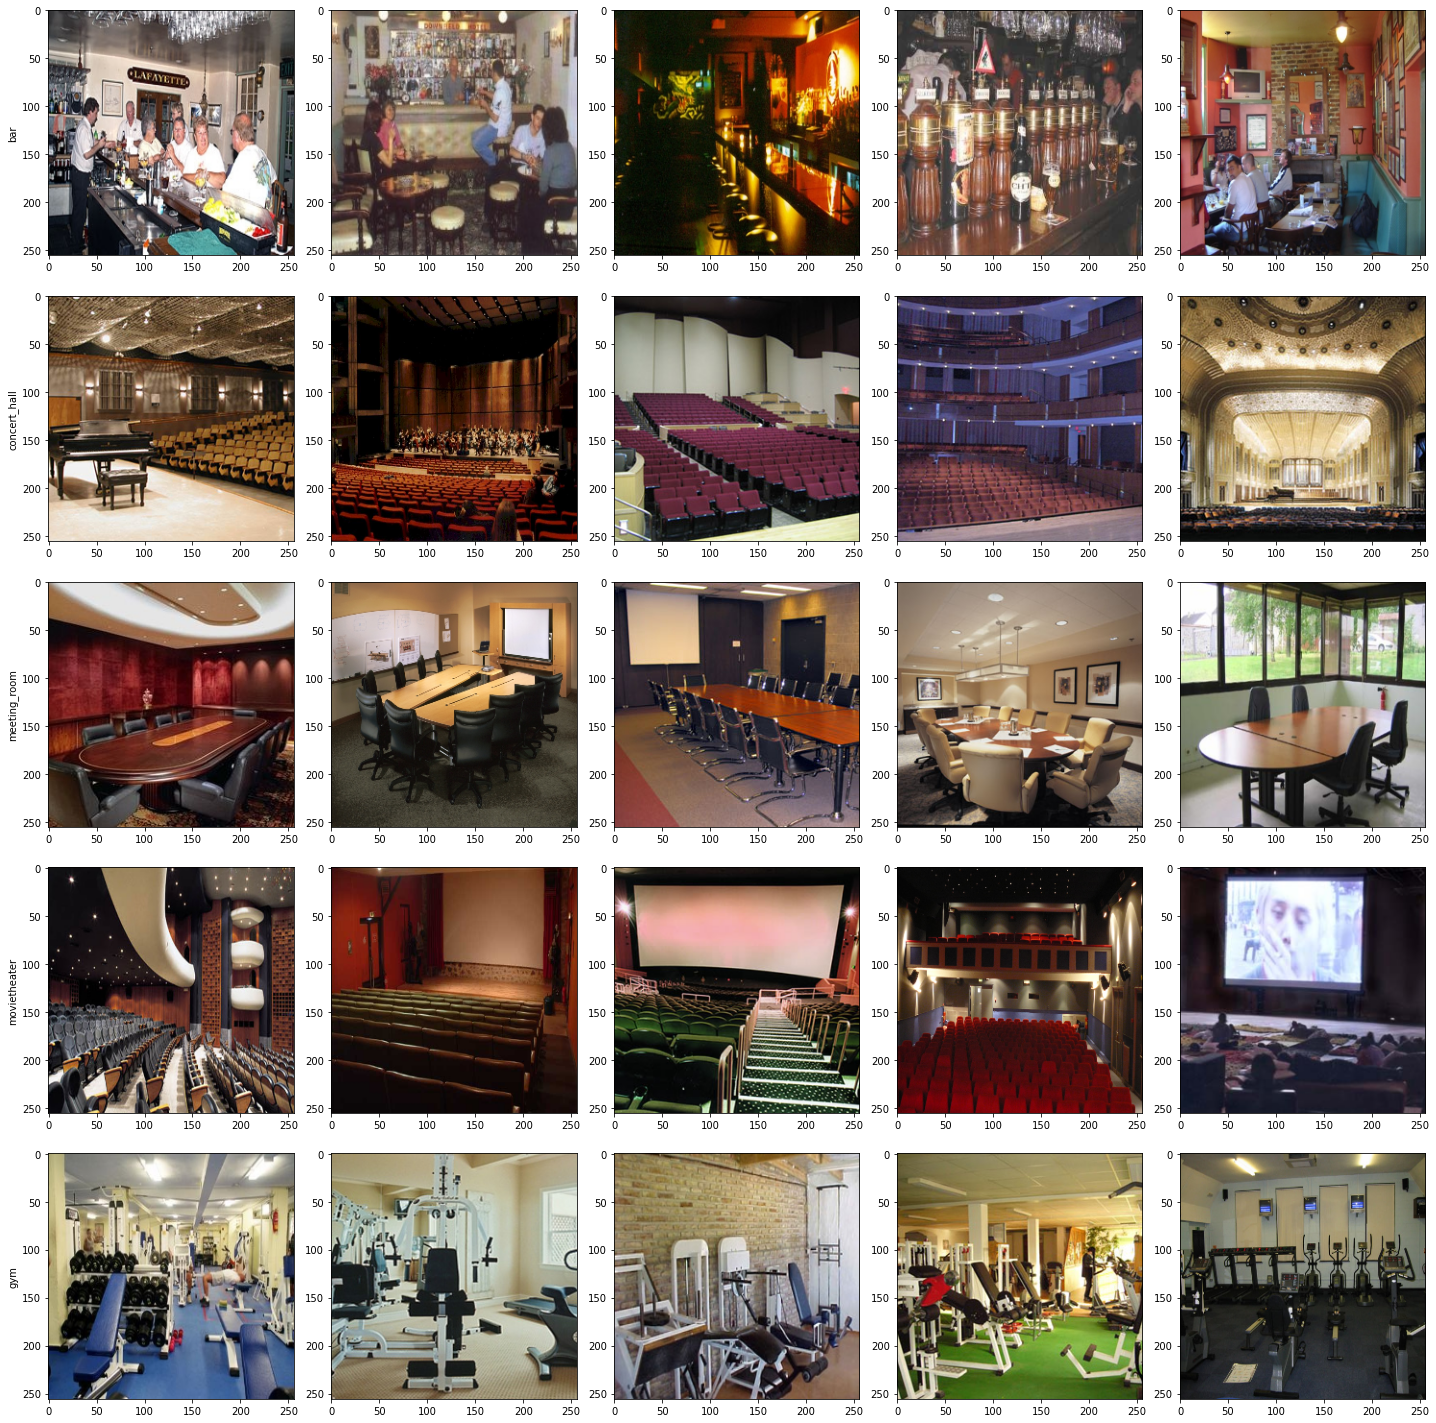

In [4]:
""" Plot sample images """

img_classes = os.listdir(imgs_path)

def read_rgb(img_path: str) -> np.ndarray:
    """
    Read color image and conver to RGB
    param: img_path: Absolute path to image
    """
    return cv.cvtColor(cv.imread(img_path, cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)

def plot_random_images(num_classes: int = 5, 
                       num_images: int = 5,
                       classes: List[str] = None,
                      ):
    """
    Plot a grid of images from a subset of classes
    :param num_classes: Number of classes to sample if classes is None
    :param num_images: Number of images per class to plot
    :param classes: List of classes to plot; if a list is passed it takes precedence over num_classes
    """
    classes_to_plot = random.sample(img_classes, num_classes) if classes is None else classes
    num_classes_to_plot = len(classes_to_plot)
    fig, axes = plt.subplots(num_classes_to_plot, num_images, figsize=(20, 20))
    for row_idx, img_class in enumerate(classes_to_plot):
        class_path = os.path.join(imgs_path, img_class)
        class_img_paths = random.sample([os.path.join(class_path, img_name) for img_name in os.listdir(class_path)], num_images)
        for col_idx, (ax, class_img_path) in enumerate(zip(axes[row_idx, :], class_img_paths)):
            if col_idx == 0:
                ax.set_ylabel(img_class)
            img = read_rgb(class_img_path)
            img = cv.resize(img, (256, 256))
            ax.imshow(img)
    fig.tight_layout()
    plt.plot()

    
plot_random_images(num_classes=5, num_images=5)

In [5]:
""" Dataset and dataloader """

class IndoorDataset(Dataset):
    
    def __init__(self, img_paths: List[str], label_encoder: LabelEncoder, transform: Callable = None):
        """
        param: img_paths: List of paths to images 
        param: transform: Optional transform to be applied on a sample
        """
        self.img_paths = img_paths
        self.transform = transform
        self.label_encoder = label_encoder
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img_t = self.transform(img)
        else:
            img_t = transforms.ToTensor()
        img_class = img_path.split('/')[-2]
        label = self.label_encoder.transform([img_class])
        return img_t, label[0]       

In [6]:
# Split data into training and validation sets
TRAIN_SIZE = 0.8
train_paths, valid_paths = train_test_split(train_valid_paths, train_size = TRAIN_SIZE)

In [7]:
# Compose transforms
IMG_SHAPE = (256, 256)
IMG_TRANSFORMS = transforms.Compose([
    transforms.Resize(IMG_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
BATCH_SIZE = 16

# Get image classes and encode labels
label_encoder = LabelEncoder()
label_encoder.fit(img_classes)

# Instantiate dataset
indoor_dataset_train = IndoorDataset(train_paths, label_encoder = label_encoder, transform=IMG_TRANSFORMS)
indoor_dataloader_train = DataLoader(indoor_dataset_train, shuffle=True, batch_size = BATCH_SIZE, num_workers=4)
indoor_dataset_valid = IndoorDataset(valid_paths, label_encoder = label_encoder, transform=IMG_TRANSFORMS)
indoor_dataloader_valid = DataLoader(indoor_dataset_valid, shuffle=False, batch_size = BATCH_SIZE, num_workers=4)

In [9]:
from pytorch_lightning import LightningModule, Trainer

class IndoorSceneClassifier(LightningModule):
    def __init__(self, num_classes: int = 67, freeze_layers: bool = True, lr: float = 1e-3):
        super().__init__()
        self.num_classes = num_classes
        self.lr = lr
        self.model = models.resnet50(pretrained=True)
        self.criterion = nn.CrossEntropyLoss()
        # Freeze weights
        if freeze_layers:
            for param in self.model.parameters():
                param.requires_grad = False
        # Get input number of features for last fully connected layer         
        fc_in_features = self.model.fc.in_features
        # Declare new classification head         
        self.model.fc = nn.Linear(fc_in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        pred = self.forward(imgs)
        loss = self.criterion(pred, labels)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        pred = self.forward(imgs)
        loss = self.criterion(pred, labels)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        optim_config = {'optimizer': optimizer, 
                        'lr_scheduler': {
                            'scheduler': scheduler,
                            'monitor': 'val_loss'
                        },
                       }
        return optim_config
           

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning import loggers

# Instantiate model class
clf_model = IndoorSceneClassifier(freeze_layers=False)
# Instantiate trainer class 
trainer = Trainer(default_root_dir='./Models/',
                  auto_lr_find=True, 
                  gpus=1, 
                  callbacks=[EarlyStopping(monitor="val_loss"), ModelCheckpoint(mode = "min", monitor = "val_loss", every_n_epochs = 5)], 
                  max_epochs=50,
                  min_epochs=5
                 )
# Automatically tune learning rate value
lr_finder = trainer.tuner.lr_find(clf_model, train_dataloaders=indoor_dataloader_train, val_dataloaders=indoor_dataloader_valid)
# Suggest new learning rate
new_lr = lr_finder.suggestion()
# Set new learning rate
clf_model.hparams.lr = new_lr

In [ ]:
# Train model
trainer.fit(clf_model, train_dataloaders=indoor_dataloader_train, val_dataloaders=indoor_dataloader_valid)